In [1]:
import deepSI
import numpy as np

class DuffingOscillator(deepSI.System_deriv):
    def __init__(self):
        super(DuffingOscillator, self).__init__(nx=2, dt=0.1)
        self.alpha = 1
        self.beta = 5
        self.gamma = 8
        self.delta = 0.02
        self.omega = 0.5

    def deriv(self,x,u):
        z1,z2 = x
        dz1 = self.gamma*u - self.delta*z1 - self.alpha*z2 - self.beta*(z2**3)
        dz2 = z1
        return [dz1,dz2]

    def h(self,x,u):
        return x[1]

In [2]:

from matplotlib import pyplot as plt
dt = np.arange(10000)*0.1
u = np.cos(0.5*dt)

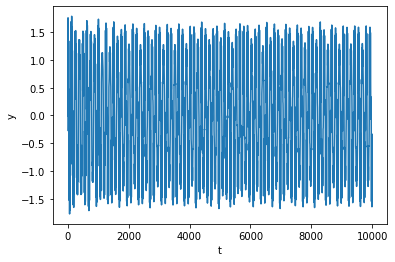

In [3]:
sys = DuffingOscillator()
data = sys.apply_experiment(deepSI.System_data(u=u))
data.plot()

In [4]:
ss_enc = deepSI.fit_systems.SS_encoder(nx=4, na=5, nb=5) #feedthrough=True
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

ss_enc.fit(train_sys_data=train, val_sys_data=val, epochs=50, batch_size=256, loss_kwargs={'nf':50})

Initilizing the model and optimizer
Size of the training array =  5.0 MB
N_training_samples = 5946, batch_size = 256, N_batch_updates_per_epoch = 23
Initial Validation sim-NRMS= 1.310145014505731


  0%|          | 0/50 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.47432484014432935
Epoch    1, sqrt loss  0.7382, Val sim-NRMS 0.4743, Time Loss: 81.0%, data: 0.4%, val: 18.6%,  8.8 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.4460743736865662
Epoch    2, sqrt loss  0.4711, Val sim-NRMS 0.4461, Time Loss: 81.6%, data: 0.3%, val: 18.1%,  8.4 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.442317656183842
Epoch    3, sqrt loss  0.4588, Val sim-NRMS 0.4423, Time Loss: 81.9%, data: 0.3%, val: 17.8%,  8.4 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.44202842236845286
Epoch    4, sqrt loss  0.4555, Val sim-NRMS  0.442, Time Loss: 81.3%, data: 0.3%, val: 18.4%,  8.7 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.44201988715017015
Epoch    5, sqrt loss  0.4535, Val sim-NRMS  0.442, Time Loss: 81.4%, data: 0.3%, val: 18.3%,  8.8 batches/se

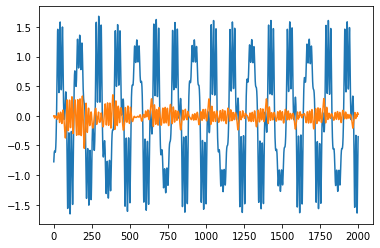

In [5]:
test_ss_enc = ss_enc.apply_experiment(test)

plt.plot(test.y)
plt.plot(test.y - test_ss_enc.y)

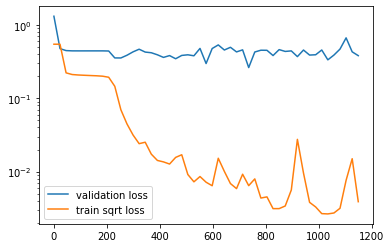

In [6]:
ss_enc.checkpoint_load_system('_last')
plt.semilogy(ss_enc.batch_id,ss_enc.Loss_val,label='validation loss')
plt.semilogy(ss_enc.batch_id,ss_enc.Loss_train,label='train sqrt loss')
plt.legend()

In [49]:
ss_enc.fn

simple_res_net(
  (net_lin): Linear(in_features=5, out_features=4, bias=True)
  (net_non_lin): feed_forward_nn(
    (net): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)

In [41]:
params = {}
for name, param in ss_enc.fn.named_parameters():
    params[name] = param.detach().numpy()

In [42]:
params.keys()

dict_keys(['net_lin.weight', 'net_lin.bias', 'net_non_lin.net.0.weight', 'net_non_lin.net.0.bias', 'net_non_lin.net.2.weight', 'net_non_lin.net.2.bias', 'net_non_lin.net.4.weight', 'net_non_lin.net.4.bias'])

In [106]:
x = np.matrix('1;2;3;4;5')
W0 = np.matrix(params["net_non_lin.net.0.weight"])
b0 = np.matrix(params["net_non_lin.net.0.bias"]).T
W2 = np.matrix(params["net_non_lin.net.2.weight"])
b2 = np.matrix(params["net_non_lin.net.2.bias"]).T
W4 = np.matrix(params["net_non_lin.net.4.weight"])
b4 = np.matrix(params["net_non_lin.net.4.bias"]).T

(64, 1)

In [112]:
from casadi import *

def relu_act(x):
    for i in np.arange(np.shape(x)[0]):
        x[i] = fmax(x[i],0)
        
    return x

In [119]:

mtimes(W4, tanh(mtimes(W2, tanh(mtimes(W0,x)+b0))+b2))+b4

DM([0.81409, 3.03415, -0.086835, -0.700095])